In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc 
from celluloid import Camera #Ver momentos
import scipy as sp
from scipy import integrate
import os.path as path
import wget

# Punto 2

a) Descargue los datos de Data

In [2]:
file = 'data.dat'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/EnergiaPotencialGas2D.txt'

if not path.exists(file):
    Path_ = wget.download(url, file)
    print('descargado')
else:
    Path_ = file
    
#Aquí se extrae la información del file
data = np.loadtxt(file)
tiempo = data[:,0]
energia_ = data[:,1]


b) Quitar el valor medio de la energía potencial

In [3]:
#Se quita el valor medio de la energía para centrarla en cero
energia = energia_ - np.mean(energia_)

c) Encuentre la transformada rápida de Fourier de los datos

In [4]:
#Transformada rápida de Fourier
fftenergia = np.fft.fft(energia)

N = len(fftenergia)

frecuenciast = np.fft.fftfreq(N)

fftenergian = np.abs(fftenergia)/N

#Aplicando nyquist 
fenergia = 2*(fftenergian[frecuenciast>0])
frecuencias = frecuenciast[frecuenciast>0]

d) Encuentre la frecuencia fundamental asociada a la frecuencia media de colisión entre partículas

In [5]:
#Frecuencia fundamental
fdom = frecuencias[np.argmax(fenergia)]

print("La frecuencia fundamental es de {:.2f}".format(fdom))

La frecuencia fundamental es de 0.00


<IPython.core.display.Javascript object>


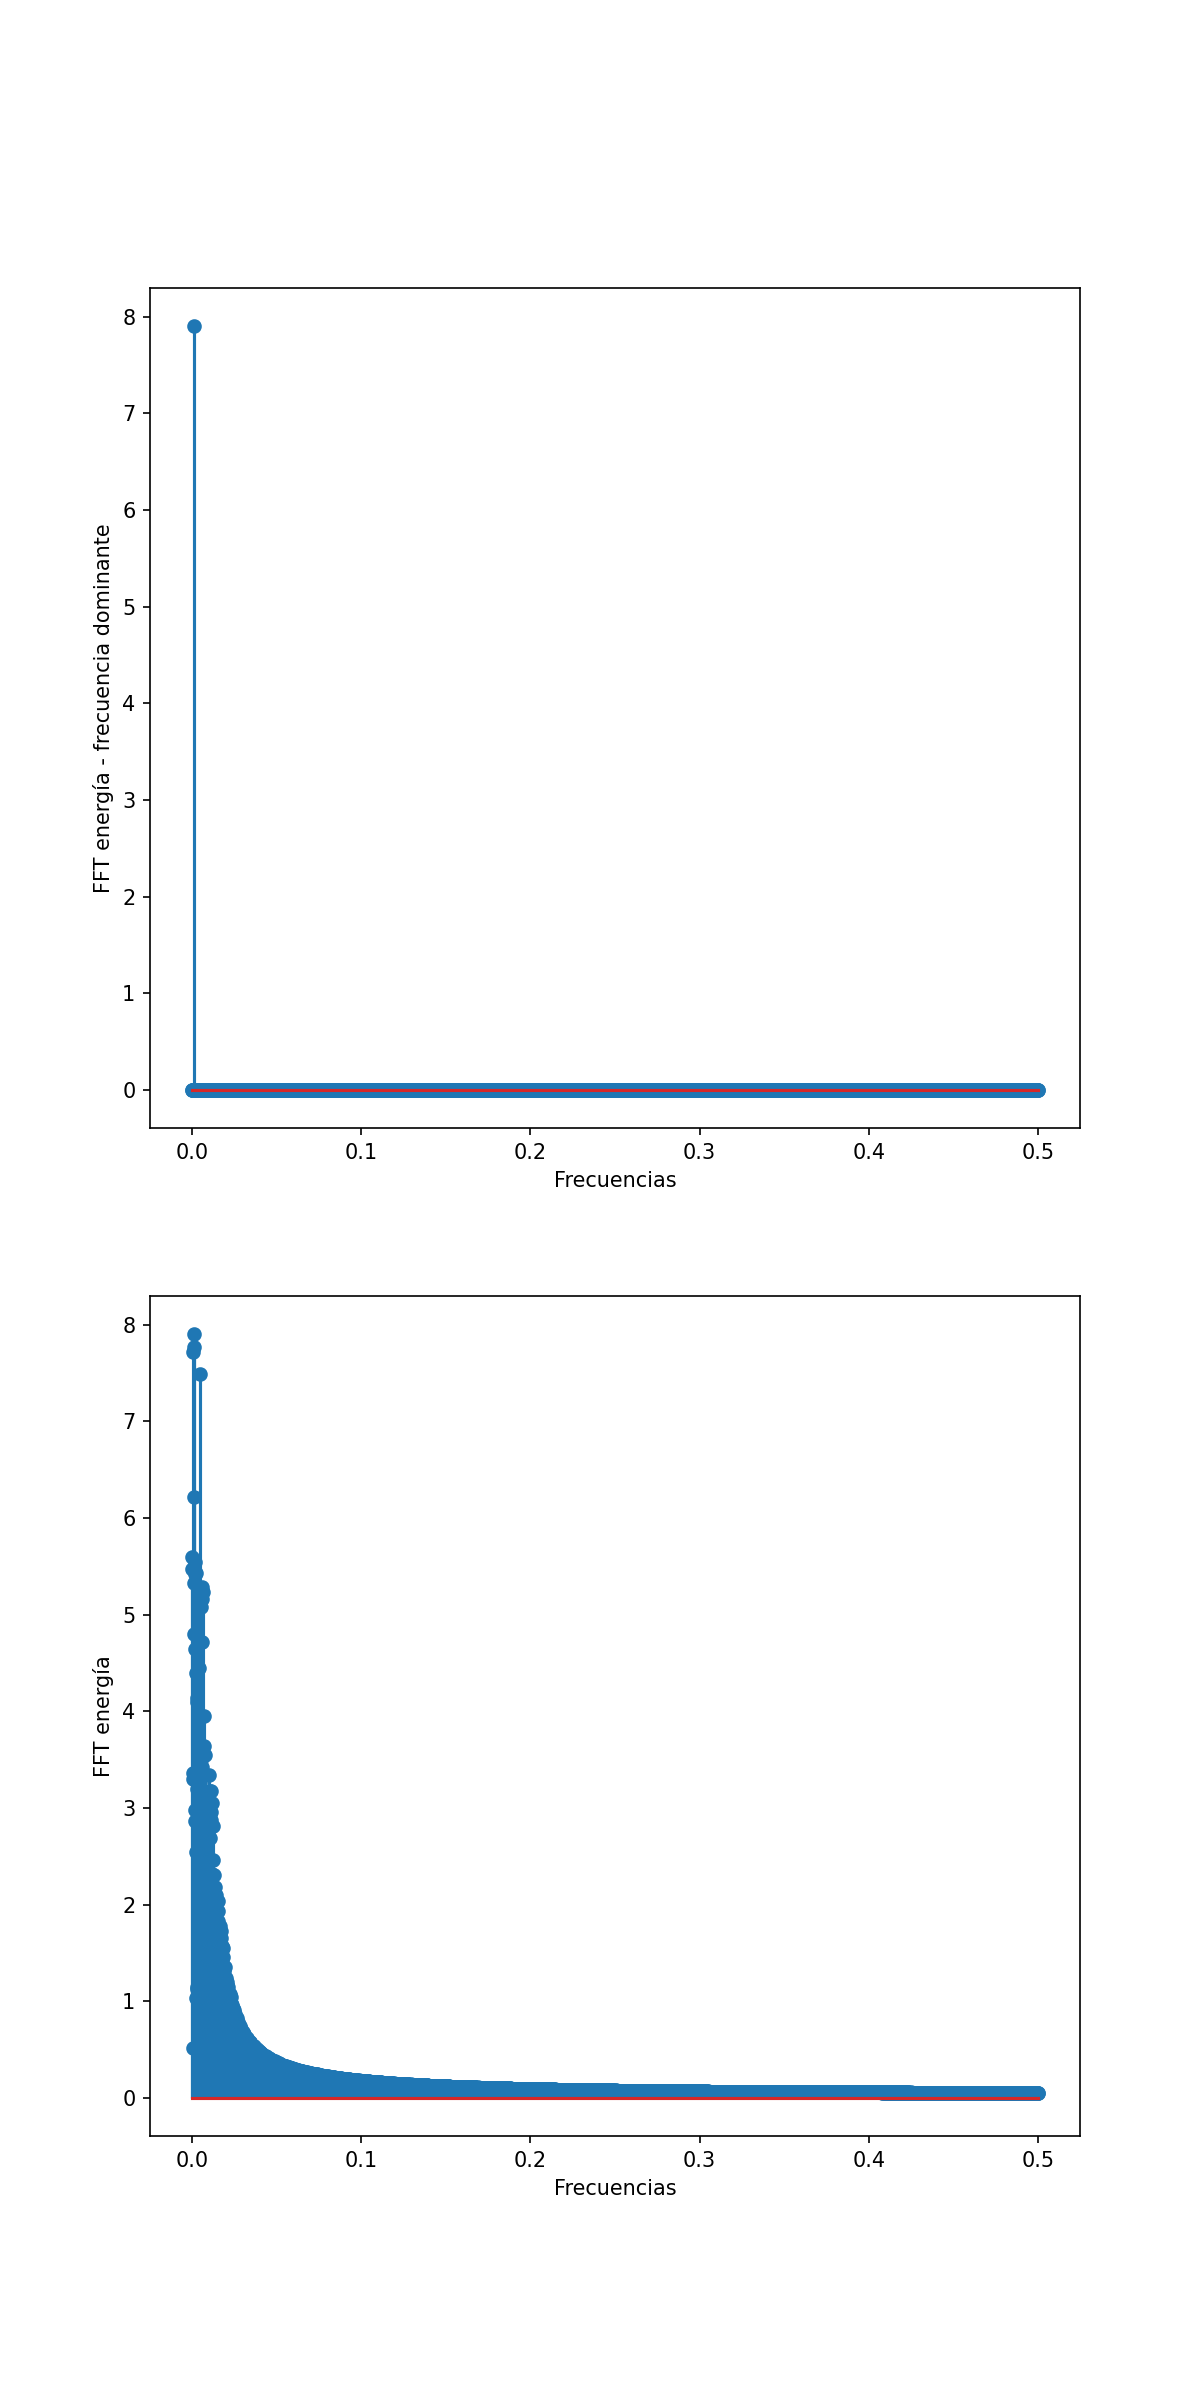

Text(0, 0.5, 'FFT energía')

In [6]:
newenergia = fenergia.copy()
newenergia[frecuencias!=fdom] = 0

fig21 = plt.figure(figsize=(8,16))
ax21 = fig21.add_subplot(2,1,1)
ax21.stem(frecuencias, newenergia, use_line_collection = True)
ax21.set_xlabel("Frecuencias")
ax21.set_ylabel("FFT energía - frecuencia dominante")

ax211 = fig21.add_subplot(2, 1, 2)
ax211.stem(frecuencias, fenergia, use_line_collection = True)
ax211.set_xlabel("Frecuencias")
ax211.set_ylabel("FFT energía")

e) Encuentre $\tau$ como $\tau$ = 1/f_{0} en pasos temporales

In [7]:
periodo = 1/fdom

f) Obtenga la figura 2. 

<IPython.core.display.Javascript object>


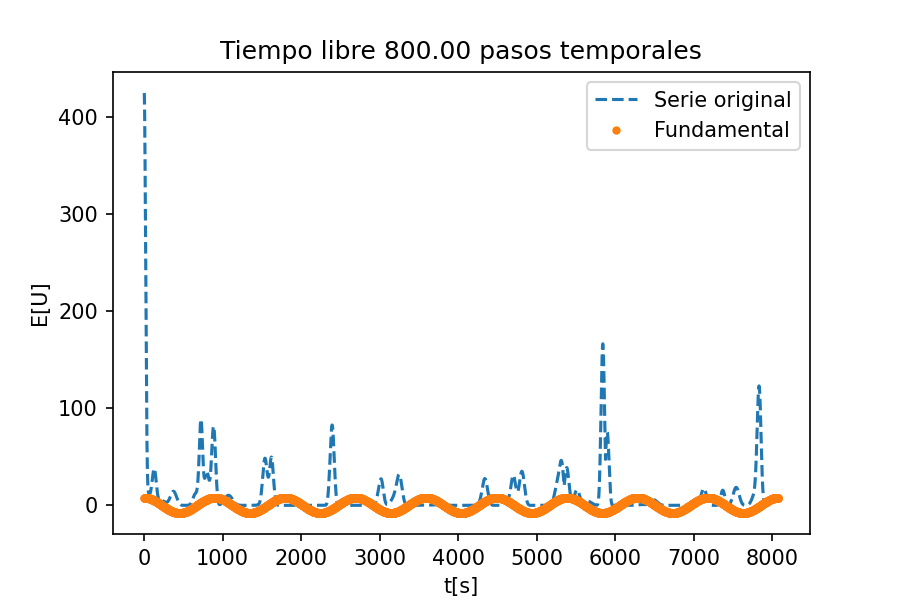

In [8]:
#Ahora hallamos la transformada inversa de Fourier
tiempo_ = np.linspace(np.min(tiempo), np.max(tiempo) + periodo, len(newenergia))*10
invenergia = np.fft.ifft(newenergia)

fig22 = plt.figure(figsize=(6,4))
ax23 = fig22.add_subplot(1,1,1)
ax23.plot(tiempo*1000, energia_, "--", label = "Serie original")
ax23.plot(tiempo_, invenergia.real*len(invenergia), ".", label = "Fundamental" )
ax23.set_xlabel("t[s]")
ax23.set_ylabel("E[U]")
ax23.set_title("Tiempo libre {:.2f} pasos temporales".format(periodo))
ax23.legend()

# Punto 3

Los incisos a, b, c y e se encuentran en el pdf adjunto.

d) Encuentre numéricamente (con algún método visto) la solución del sistema de ecuaciones

In [9]:
#Se definen las condiciones del problema

#Valor de la constante C
C = 4

#Condiciones iniciales de la temperatura.
T10 = 400
T20 = 200

condi = [T10 , T20]

#Condiciones iniciales con las derivadas
condd = [-C*(T10-T20), C*(T10-T20)]



In [10]:
#Discretización
N = 100
t = np.linspace(0.,2.,N)

In [11]:
#Ecuaciones diferenciales
def f1(T1, T2, C):
    return (-C*(T1-T2))

def f2(T1, T2, C):
    return (C*(T1-T2))

In [12]:
#Soluciones analíticas

#Solución analítica de T1
def sol1(C, t, T10, T20):
    return (((T10 + T20)/2) + (((T10 - T20)/2)*np.exp(-2*C*t)))

#Solución analítica de T2
def sol2(C, t, T10, T20):
    return (((T10 + T20)/2) - (((T10 - T20)/2)*np.exp(-2*C*t)))

In [13]:
#Método de Euler
def GetEuler(f1, f2, condi, condd, t):
    
    h = (t[-1]- t[0])/(len(t)-1)
    
    T1 = np.zeros(len(t))
    T2 = np.zeros(len(t))
    
    T1[0] = condi[0] 
    T2[0] = condi[1]
    
    K1 = np.zeros(2)
    
    for i in range(1, len(t)):
        
        K1[0] = f1(T1[i-1], T2[i-1], C)
        K1[1] = f2(T1[i-1], T2[i-1], C)
        
        T1[i] = T1[i-1] + h*K1[0] 
        T2[i] = T2[i-1] + h*K1[1] 
        
    return (T1, T2)

In [14]:
#Método de Euler mejorado
def GetEuler2(f1, f2, condi, condd, t):
    
    h = (t[-1]- t[0])/(len(t)-1)
    
    T1 = np.zeros(len(t))
    T2 = np.zeros(len(t))
    
    T1[0] = condi[0]
    T2[0] = condi[1]
    
    K1 = np.zeros(2)
    K2 = np.zeros(2)
    
    for i in range(1, len(t)):
        
        K1[0] = f1(T1[i-1], T2[i-1], C)
        K1[1] = f2(T1[i-1], T2[i-1], C)
        
        K2[0] = f1(T1[i-1]+ h*K1[0], T2[i-1] + h*K1[0], C)
        K2[1] = f2(T1[i-1]+ h*K1[0], T2[i-1] + h*K1[0], C)
        
        T1[i] = T1[i-1] + 0.5*h*(K1[0]+K2[0]) 
        T2[i] = T2[i-1] + 0.5*h*(K1[1]+K2[1]) 
        
    return (T1, T2)

<IPython.core.display.Javascript object>


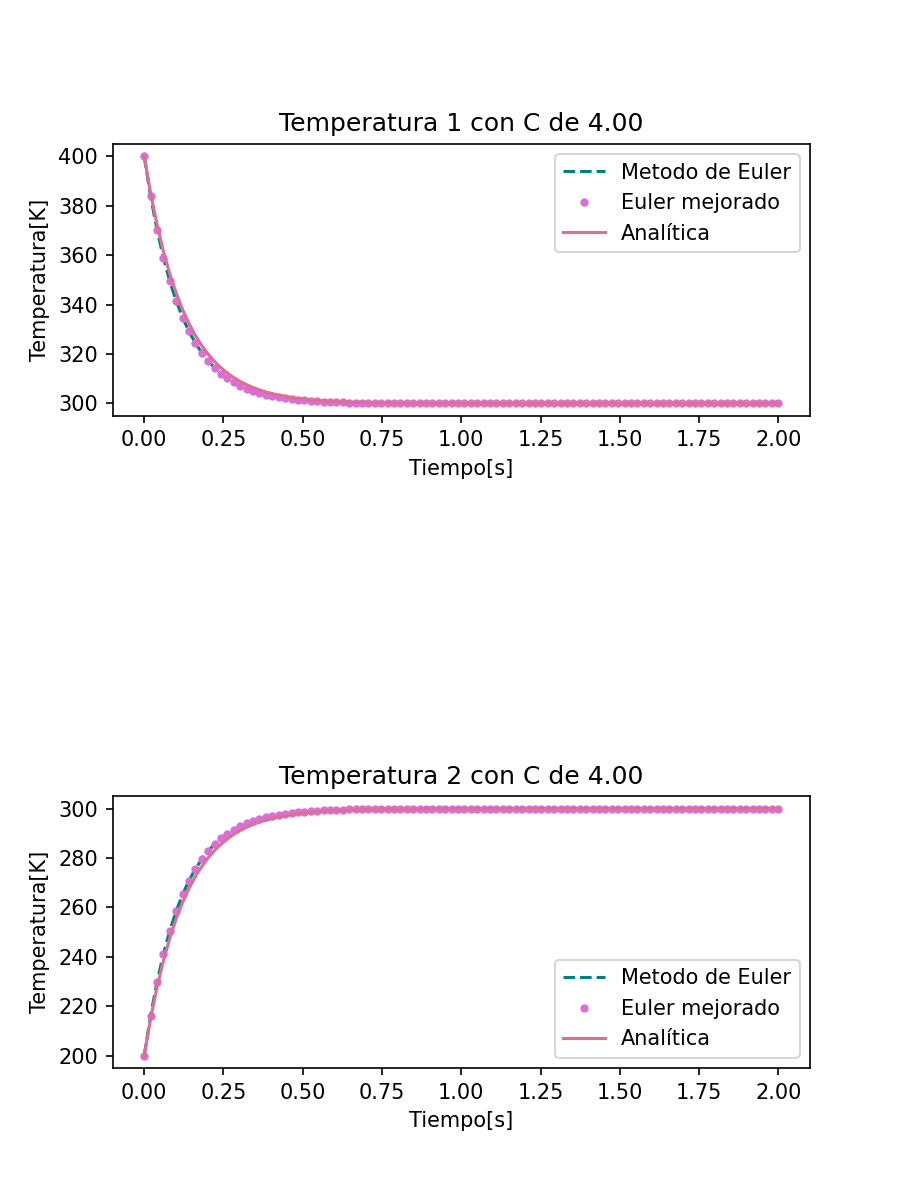

In [15]:
#Soluciones a las temperaturas usando el método de Euler 
T11, T21 = GetEuler(f1, f2, condi, condd, t)

#Soluciones a las temperaturas usando el método de Euler mejorado
T12, T22 = GetEuler2(f1, f2, condi, condd, t)

#Soluciones analíticas de las temperaturas
T1A = sol1(C, t, T10, T20)
T2A = sol2(C, t, T10, T20)

fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(t, T11,"--", color = "teal", label = "Metodo de Euler")
ax1.plot(t, T12, ".", color = "orchid", label = "Euler mejorado")
ax1.plot(t, T1A, color = "palevioletred",label = "Analítica")
ax1.set_title("Temperatura 1 con C de {:.2f}".format(C))
ax1.set_xlabel("Tiempo[s]")
ax1.set_ylabel("Temperatura[K]")
ax1.legend()

ax2 = fig.add_subplot(3,1,3)
ax2.plot(t, T21, "--", color = "teal",  label = "Metodo de Euler")
ax2.plot(t, T22, ".", color = "orchid",label = "Euler mejorado")
ax2.plot(t, T2A, color = "palevioletred", label = "Analítica")
ax2.set_title("Temperatura 2 con C de {:.2f}".format(C))
ax2.set_xlabel("Tiempo[s]")
ax2.set_ylabel("Temperatura[K]")
ax2.legend()